# Saliency Maps for Explainability with ResNet18

Saliency refers to what’s noticeable or important in an image. CNNs are often referred to as black-box models that have no interpretability because understanding how they arrive at their decisions can be challenging. This is not ideal and is in conflict with ethical AI principles, preventing us from harnessing its full potential in practical applications. Saliency maps offer a way to interpret CNN decisions by highlighting which parts of an image contribute most to a particular prediction or classification.

Saliency maps in deep learning were first witnessed in the paper titled Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps: https://arxiv.org/abs/1312.6034. This notebook is an implementation of the image-specific Class Saliency Visualisation method described in this paper.


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import  torchvision.transforms as transforms

/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load pretrained resnet model
model = torchvision.models.resnet18(pretrained=True)
model

/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Define transformation to normalize input image data according to pre-trained model requirements
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Define inverse transformation to revert normalized image back to its original form for visualization
inv_normalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.255], std = [1/0.229, 1/0.224, 1/0.255])

# Define a sequence of transformations to prepare the input image for the pre-trained model
transform = transforms.Compose([transforms.Resize((224, 224)),  # Resize image to the dimensions expected by the pre-trained model
                                transforms.ToTensor(),          # Convert PIL image to tensor
                                normalize,                      # Normalize the image data
                              ])

In [4]:
def saliency(img, model):
    '''
        Compute the saliency map of an input image with respect to the model's prediction.

        Args:
        - img (PIL.Image): Input image.
        - model (torch.nn.Module): Pre-trained neural network model.

        Returns:
        - None: Display the original image and its corresponding saliency map.
    '''

    # Disable gradient calculation for model parameters since we're not training
    for param in model.parameters():
        param.requires_grad = False
    
    # Set model to evaluation mode
    model.eval()

    # Transform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    # Set requires_grad to True for input to compute gradients 
    input.requires_grad = True

    # Forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)

    # Backward pass to get gradients of predicted class score w.r.t. input image
    score.backward()

    # Get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    
    # Normalize saliency map to [0, 1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    # Apply inverse transform on the input image
    with torch.no_grad():
        input_img = inv_normalize(input[0])

    # Plot the original image and its saliency map
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.magma)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


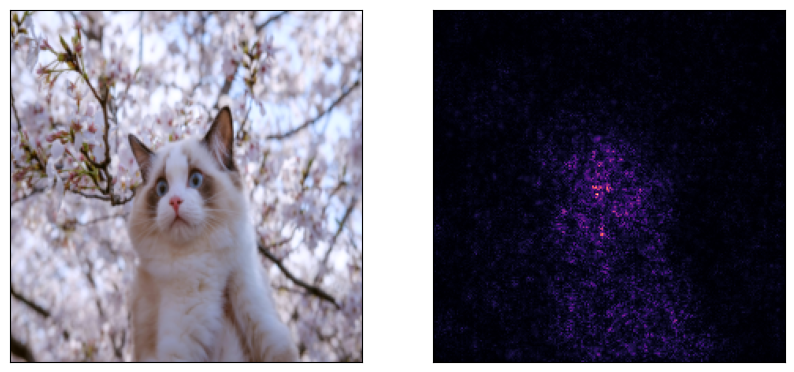

In [5]:
# Load the image
img = Image.open('images/kitty.jpg').convert('RGB')

saliency(img, model)

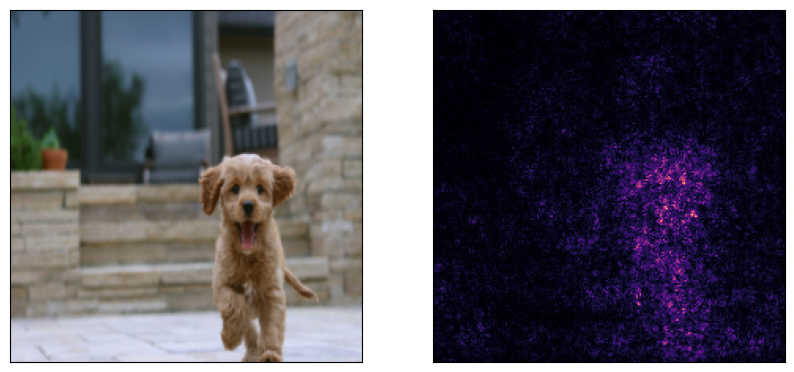

In [6]:
# Load the image
img = Image.open('images/pup.jpg').convert('RGB')

saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


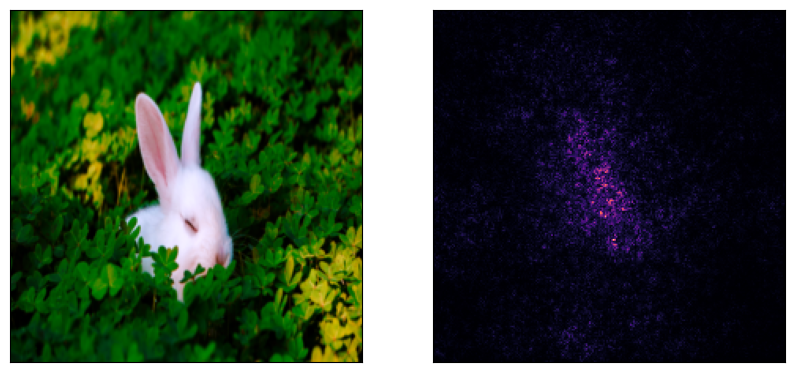

In [7]:
# Load the image
img = Image.open('images/bunny.jpg').convert('RGB')

saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


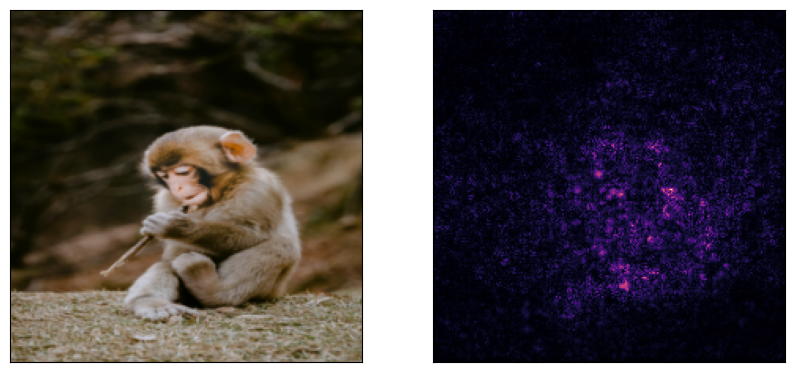

In [8]:
# Load the image
img = Image.open('images/monkey.jpg').convert('RGB')

saliency(img, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


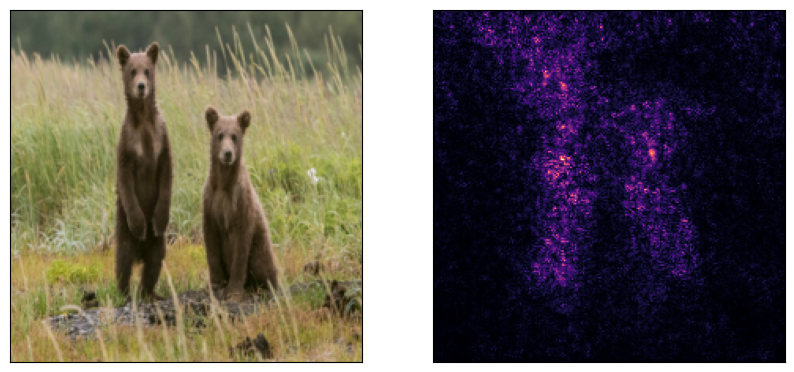

In [9]:
# Load the image
img = Image.open('images/bear.jpg').convert('RGB')

saliency(img, model)

**CONCLUSION**: The generation of saliency maps for the provided images has proven to be a valuable technique for identifying regions of interest and understanding visual attention. 